# Group 07 Assignment 2

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import statistics
import operator
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors

## Fully Connected Neural Network

In [122]:
class metrics: 
    def __init__(self, y_true, y_pred): 
        self.y_true = y_true
        self.y_pred = y_pred
        return
    
    def rmse(self):
        return np.sqrt(np.mean((self.y_pred - self.y_true)**2))
    
    def mae(self):
        return np.sum(np.absolute(self.y_pred - self.y_true))
    
    def mse(self): 
        return np.square(np.subtract(self.y_pred, self.y_true)).mean()
    
def mse(y_pred, y_true): 
    return np.square(np.subtract(y_pred, y_true)).mean()
        

In [299]:
def initialize_deep_parameters(layer_dims, random_seed):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in the network
    `The first layer should be the number of x input columns or number of features, so that after every iteration the dimension of the input x remains the same.`

    where (d, h, K): 
        d: dimension of input layer
        h: dimension of hidden layer 
        K: dimension of output layer

    and further (d, h1, h2, h3.... , K)
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(random_seed) 
    params = {}
    L = len(layer_dims)
    params['H0'] = np.zeros((layer_dims[0]))
    for l in range(1, L):
        # params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01 # damping the random values by a factor of 0.01
        params['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01 # (input layers, output layers)
        # At any layer l, the 
        params['b' + str(l)] = np.ones((layer_dims[l])) # initialise the bias with zero
        params['H' + str(l)] = np.zeros((layer_dims[l], 1)) # initialise the hidden states
        params['A' + str(l)] = np.zeros((layer_dims[l], 1)) # initialise the activation values
        
        assert(params['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        assert(params['b' + str(l)].shape == (layer_dims[l],))
        assert(params['H' + str(l)].shape == (layer_dims[l], 1))
        
    return params

class FCNN():
  def __init__(self):
    return

  def init_hidden_layer(self, prev_layer_neurons, num_neurons):
    w = np.random.randn(prev_layer_neurons, num_neurons)
    return w

  def logistic_af(self, a):
    """
    a.shape = (num_neurons_layer, 1)
    activation_value: o/p array of shape= ()
    """
    return 1/(1+np.exp(-a))
  
  def linear(self, a): 
    return a

  def output_of_layer(self, weight_mtx, input_to_layer, activation):
    """
    weight_mtx: given by init_hidden_layer(). shape = (num_neurons_prev_layer, current_layer_neurons)
    input_to_layer = shape: (weight_mtx.shape[0],) where weight_mtx.shape[0] = num of neurons in prev layer
    """
    a = np.dot(weight_mtx.T, input_to_layer)
    h = activation(a)
    return a, h

  def fcnn_arch(self, train_df, num_neurons_hidden, num_output_neurons):
    """
    train_df: is just train dataframe. needed only for getting i/p dim=d
    num_neurons_hidden = dictionary of {hidden_layer_num: number of neurons in it}. Ex: {1: 16, 2: 32}
    num_output_neurons: integer of num of output neurons. =1 for regression, 3 for classification
    """
    input_neurons = train_df.shape[1]-1#d
    # because the need to remove the shape of one target variable in the whole dataframe
    num_hidden_layers = len(num_neurons_hidden.keys())
    layer_weights = {}
    w_h1 = self.init_hidden_layer(input_neurons+1, num_neurons_hidden[1])
    layer_weights[1] = w_h1
    for layer in range(2, num_hidden_layers+1):#second hidden layer onwards to all hidden layers. excluding o/p layer
      w = self.init_hidden_layer(num_neurons_hidden[layer-1]+1, num_neurons_hidden[layer])
      layer_weights[layer] = w
    w_o = self.init_hidden_layer(num_neurons_hidden[num_hidden_layers]+1, num_output_neurons)#output layer weights. o/p layer neurons will be = no. of classes of problem
    layer_weights[num_hidden_layers+1] = w_o
    return layer_weights

  def fcnn_forward(self, model_input, weights_dict, last_activation_function):
    """
    model_input: one input sample: shape = (d+1,)
    """
    weighted_inputs = {}
    layer_outputs = {}
    layer_outputs[0] = model_input#used in delta_w computation. as input to hidden layer 1 is inp to model or o/p of inp layer 0
    a, output = self.output_of_layer(weights_dict[1], model_input, activation=self.logistic_af)#output of layer h1
    weighted_inputs[1] = a
    output= np.hstack([np.ones((1)), output])
    layer_outputs[1] = output#has 1 appended in the beginning
    for hidden_layer in range(2,len(weights_dict.keys())):#bec dict keys can be in shuffled order
      a, output = self.output_of_layer(weights_dict[hidden_layer], output, activation=self.logistic_af)
      weighted_inputs[hidden_layer] = a
      output= np.hstack([np.ones((1)), output])
      layer_outputs[hidden_layer] = output
    a, model_output = self.output_of_layer(weights_dict[len(weights_dict.keys())], output, activation= last_activation_function)
    weighted_inputs[len(weights_dict.keys())] = a
    layer_outputs[len(weights_dict.keys())] = model_output # len(weight_dict.keys(), output of the final layer)
    return weighted_inputs, layer_outputs

  def instantaneous_error(self, y_n, y_pred):
    """
    y_n: actual shape = (K=3,)
    y_pred: predicted: output of perceptron_forward fn. shape = (K=3,)
    """
    err = y_n - y_pred
    error = 0.5*np.dot(err.T, err) #For matrix squaring
    return error

  def logistic_af_derivative(self, a):
    derivative = self.logistic_af(a)* (1-self.logistic_af(a))
    return derivative

  def del_op(self, a_o, y_n, y_pred, output_activation_function):
    """
    a_o: weighted sum input to output layer.(activation not applied yet) shape = (K,). first o/p of output_of_layer
    """
    err = y_n - y_pred
    if output_activation_function == 'sigmoid':
      del_o = err* self.logistic_af_derivative(a_o)
    elif output_activation_function == 'linear': 
      del_o = err # because of perfectly linear activation function with slope 45 degrees
    return del_o

  def del_hidden(self, del_next_layer, w_nxt_layer, a_current_layer):#del of h_n-1, i.e. pre-final layer
    """
    del_next_layer shape = (num_neurons_nxt_layer, )
    w_nxt_layer shape = (num_neurons_current_layer+1, num_neurons_nxt_layer) || since (input neurons, output neurons)
    a_current_layer = dim = (num_neurons_current_layer,) it is weighted sum of inputs to current layer. will fetch from weighted_inputs
    o/p of fcnn_forward
    """
    w_effective= w_nxt_layer[1:,:]#without bias
    first_term = np.dot(w_effective, del_next_layer)
    second_term = self.logistic_af(a_current_layer)#a_current_layer = output_of_layer(weight_mtx, input_to_layer=rawo/p of prev layer
    del_h = first_term*second_term
    return del_h

  def delta_layer(self, lr, del_layer, op_previous_layer):
    """
    op_previous_layer: raw input to the layer whose delta we're computing. shape = (num_neurons_previous_layer, 1)
    del_layer = del of the concerned layer. shape = (num_neurons_current_layer, 1)
    """
    # op_previous_layer = np.hstack([np.ones((1)), op_previous_layer])
    tmp_mtx = np.dot(op_previous_layer.reshape(-1,1), del_layer.reshape(1,-1))
    # print(tmp_mtx.shape)
    # delta_w = lr*op_previous_layer*del_layer
    delta_w = lr*tmp_mtx
    return delta_w

  def compute_gradients(self, layer_weights, weighted_inputs, layer_outputs, y_n, lr, output_activation_function):
    del_layers_dict = {}
    num_layers = len(layer_weights.keys())
    del_output_layer = self.del_op(weighted_inputs[num_layers], y_n, layer_outputs[num_layers], output_activation_function)
    del_layers_dict[num_layers] = del_output_layer
    delta_dict = {}
    delta_dict[num_layers] = self.delta_layer(lr, del_output_layer, layer_outputs[num_layers-1])
    updated_w = layer_weights.copy()

    # layer_weights[num_layers] = layer_weights[num_layers] + delta_dict[num_layers]- doubt: updated weights used in each layer del?

    for hidden_layer in reversed(range(1, num_layers)):#2,1
      # print(hidden_layer)
      del_next = del_layers_dict[hidden_layer+1]
      del_layers_dict[hidden_layer] = self.del_hidden(del_next, layer_weights[hidden_layer+1], weighted_inputs[hidden_layer])
      delta_dict[hidden_layer] = self.delta_layer(lr, del_layers_dict[hidden_layer], layer_outputs[hidden_layer-1])
    return delta_dict

  def train_fcnn_clf(self, train_data, lr, max_epochs, num_output_neurons, num_neurons):
    """
    num_neurons = dictionary for hidden layer : {hidden_layer_num: number of neurons in it}. Ex: {1: 16, 2: 32}
    num_output_neurons = integer of num of output neurons. =1 for regression, 3 for classification
    """
    N = train_data.shape[0]
    y_arr = train_data['class'].values
    #converting y_arr integer class value into one-hot numpy array of shape (3,1)
    labels = np.zeros((y_arr.size, y_arr.max()))  # initialize empty (all zero) label array
    labels[np.arange(y_arr.size), y_arr-1] = 1  # add ones in indices where we have a value
    # labels is one hot 2d numpy array
    weights_dict = self.fcnn_arch(train_data, num_neurons, 3)#random weights initialization
    epoch = 0
    average_error = []
    # average_error = [100]
    # error_diff = 100
    # while np.abs(error_diff)>=0.001:#change convergence criteria to threshold
    while epoch<max_epochs:
      # print(epoch)
      epoch_total_error = 0# current epoch's avg error
      for count, row_index in enumerate(train_data.index):#iterating over all samples. improvement scope: data shuffle each epoch
        x_n = train_data.loc[row_index,:].to_numpy()[:-1]
        x_n = np.hstack([np.ones((1)), x_n])#shape = (3,)
        y_n = labels[count, :]#shape = (3,)
        # print(labels)
        # print(y_n)
        weighted_inputs, layer_outputs = self.fcnn_forward(x_n, weights_dict, last_activation_function=self.logistic_af)#forward function
        num_layers = len(weights_dict.keys())
        y_pred = layer_outputs[num_layers]

        # backpropagation gradient computation
        instant_error = self.instantaneous_error(y_n, y_pred)
        epoch_total_error = epoch_total_error+instant_error
        delta_w_dict = self.compute_gradients(weights_dict, weighted_inputs, layer_outputs, y_n, lr, output_activation_function = 'sigmoid')
        #weights update
        for layer in weights_dict.keys():
          weights_dict[layer] = weights_dict[layer]+delta_w_dict[layer]
      average_error.append(epoch_total_error/N)
      epoch = epoch+1
      # error_diff = average_error[epoch]- average_error[epoch-1]
    return average_error, weights_dict
  
  def test_clf(self, test_data, weights_dict):
    N = test_data.shape[0]
    y_arr = test_data['class'].values#shape= (300,)
    y_pred = []
    for count, row_index in enumerate(test_data.index):#iterating over all samples. improvement scope: data shuffle each epoch
      x_n = test_data.loc[row_index,:].to_numpy()[:-1]
      x_n = np.hstack([np.ones((1)), x_n])#shape = (3,)
      weighted_inputs, layer_outputs = self.fcnn_forward(x_n, weights_dict, last_activation_function=self.logistic_af)#forward function
      num_layers = len(weights_dict.keys())
      y_hat = layer_outputs[num_layers]
      # print(y_hat)
      y_hat = y_hat.argmax()+1
      y_pred.append(y_hat)
    cm = confusion_matrix(y_arr,y_pred)
    # print(cm)
    return cm, accuracy_score(y_arr, y_pred)*100
  
  def train_regressor(self, train_data, lr, max_epochs, num_output_neurons, num_neurons):
    """
    num_neurons = dictionary for hidden layer : {hidden_layer_num: number of neurons in it}. Ex: {1: 16, 2: 32}
    num_output_neurons = integer of num of output neurons. =1 for regression, 3 for classification
    """
    N = train_data.shape[0] # number of iterations

    # y_arr = train_data['class'].values
    y_arr = train_data['y'].values
    # print('y_arr', type(y_arr), y_arr.shape)
    weights_dict = self.fcnn_arch(train_data, num_neurons, num_output_neurons) #random weights initialization
    epoch = 0 # epoch initialization
    average_error = []
    # while np.abs(error_diff)>=0.001:#change convergence criteria to threshold
    while epoch<max_epochs:
      epoch_total_error = 0 # current epoch's avg error
      for count, row_index in enumerate(train_data.index):#iterating over all samples. improvement scope: data shuffle each epoch
        x_n = train_data.loc[row_index,:].to_numpy()[:-1]
        x_n = np.hstack([np.ones((1)), x_n]) 
        try:
          y_n = y_arr[count, :] # works only when there are 2 variable outputs
        except: 
          y_n = y_arr[count] # works with univariate output, means only one target variable to be predicted
        weighted_inputs, layer_outputs = self.fcnn_forward(x_n, weights_dict, last_activation_function=self.linear)#forward function
        num_layers = len(weights_dict.keys())
        y_pred = layer_outputs[num_layers]

        # backpropagation gradient computation
        instant_error = self.instantaneous_error(y_n, y_pred)
        epoch_total_error = epoch_total_error+instant_error
        delta_w_dict = self.compute_gradients(weights_dict, weighted_inputs, layer_outputs, y_n, lr, output_activation_function='linear')
        
        #weights update
        for layer in weights_dict.keys():
          weights_dict[layer] = weights_dict[layer]+delta_w_dict[layer]
      average_error.append(epoch_total_error/N) # per epoch average error
      epoch = epoch+1
      # error_diff = average_error[epoch]- average_error[epoch-1]
    return average_error, weights_dict
  
  def test_regressor(self, test_data, weights_dict):
    N = test_data.shape[0]
    y_arr = test_data['y'].to_list()
    y_pred = []
    for count, row_index in enumerate(test_data.index):#iterating over all samples. improvement scope: data shuffle each epoch
      x_n = test_data.loc[row_index,:].to_numpy()[:-1]
      x_n = np.hstack([np.ones((1)), x_n])
      weighted_inputs, layer_outputs = self.fcnn_forward(x_n, weights_dict, last_activation_function=self.linear)#forward function
      num_layers = len(weights_dict.keys())
      y_hat = layer_outputs[num_layers]
      y_pred.append(y_hat[0])
    rmse = metrics(np.array(y_pred), np.array(y_arr)).rmse()
    return y_arr, y_pred, rmse

  def get_neuronal_plots(self, test_data, weights_dict):
    N = test_data.shape[0]
    y_arr = test_data['y'].to_list()
    y_pred = []
    for count, row_index in enumerate(test_data.index):#iterating over all samples. improvement scope: data shuffle each epoch
      # setting values
      x_n = test_data.loc[row_index,:].to_numpy()[:-1]
      x_n = np.hstack([np.ones((1)), x_n])
      model_input = x_n

      weighted_inputs = {}
      layer_outputs = {}
      layer_outputs[0] = model_input#used in delta_w computation. as input to hidden layer 1 is inp to model or o/p of inp layer 0
      #activation and layer output
      a, output = self.output_of_layer(weights_dict[1], model_input, activation=self.logistic_af)#output of layer h1
      weighted_inputs[1] = a
      output= np.hstack([np.ones((1)), output])
      layer_outputs[1] = output#has 1 appended in the beginning
      for hidden_layer in range(2,len(weights_dict.keys())):#bec dict keys can be in shuffled order
        a, output = self.output_of_layer(weights_dict[hidden_layer], output, activation=self.logistic_af)
        weighted_inputs[hidden_layer] = a
        output= np.hstack([np.ones((1)), output])
        layer_outputs[hidden_layer] = output
      a, model_output = self.output_of_layer(weights_dict[len(weights_dict.keys())], output, activation= self.linear)
      weighted_inputs[len(weights_dict.keys())] = a
      layer_outputs[len(weights_dict.keys())] = model_output # len(weight_dict.keys(), output of the final layer)
      # return weighted_inputs, layer_outputs
      


      num_layers = len(weights_dict.keys())
      y_hat = layer_outputs[num_layers]
      y_pred.append(y_hat[0])

    print(layer_outputs.keys(), len(layer_outputs[1]), layer_outputs)
    rmse = metrics(np.array(y_pred), np.array(y_arr)).rmse()
    return y_arr, y_pred, rmse
  
  

### Cross Validation

In [124]:
def cross_validation_clf(layer_neurons_dict, val_data, max_epochs = 900):
  skf = StratifiedKFold(n_splits=2, shuffle=False)

  X = val_data.iloc[:, :-1]
  Y = val_data.iloc[:, -1]
  accuracy_lst = []
  for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    # print(f"Fold {i}:")
    tr_df = val_data.loc[val_data.index[train_index]]
    tst_df = val_data.loc[val_data.index[test_index]]
    model = FCNN()
    ls_average_error, ls_weights_dict = model.train_fcnn_clf(tr_df, 0.01, max_epochs, 3, layer_neurons_dict)
    cm, accuracy = model.test_clf(tst_df, ls_weights_dict)
    accuracy_lst.append(accuracy)
  mean_accuracy = statistics.mean(accuracy_lst)
  return mean_accuracy

def cross_validation_reg(layer_neurons_dict, val_data, max_epochs = 900):
  kf = KFold(n_splits=2, shuffle=False)

  X = val_data.iloc[:, :-1]
  Y = val_data.iloc[:, -1]
  rmse_lst = []
  for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
    # print(f"Fold {i}:")
    tr_df = val_data.loc[val_data.index[train_index]]
    tst_df = val_data.loc[val_data.index[test_index]]
    model = FCNN()
    reg_average_error, reg_weights_dict = model.train_regressor(train_data = tr_df,lr=0.01, max_epochs = max_epochs, num_output_neurons=1, num_neurons = layer_neurons_dict)
    uni_y_true, uni_y_pred, rmse = model.test_regressor(test_data=tst_df, weights_dict = reg_weights_dict)
    
    rmse_lst.append(rmse)
  
  mean_rmse = statistics.mean(rmse_lst)
  return mean_rmse


**Validate all possible Architectures**

In [125]:
def validate_all_archs(val_data, lst, max_epochs):
  """
  for more than one hidden layer arch
  @regression: 
  """
  arch_wise_val_accuracy = {}
  arch_dict = {}# will contain all architectures' dimensions 
  for i in range(len(lst)):#for each combination of neurons
    if i<len(lst):
      layer_neurons_dict = {}
      layer_neurons_dict[1] = lst[i]#lst[i]
      layer_neurons_dict[2] = lst[i]#lst[i+1]
      arch_dict[i] = layer_neurons_dict
      accuracy_of_arch = cross_validation_clf(layer_neurons_dict, val_data, max_epochs)
      arch_wise_val_accuracy[i] = accuracy_of_arch

  return arch_wise_val_accuracy, arch_dict

def validate_all_archs_reg(val_data, lst, max_epochs):
  """
  @val_data: pd.Dataframe() which was split into train, val, and test
  for more than one hidden layer arch
  """
  arch_wise_val_rmse = {}
  arch_dict = {} # will contain all architectures' dimensions 
  for i in range(len(lst)):#for each combination of neurons
    if i<len(lst):
      layer_neurons_dict = {}
      layer_neurons_dict[1] = lst[i]#lst[i] # key: 1 - values first layer contains
      layer_neurons_dict[2] = lst[i]#lst[i+1] # key: 2 - values second layer contains
      arch_dict[i] = layer_neurons_dict # for documenting the values
      mean_rmse_arch = cross_validation_reg(layer_neurons_dict, val_data, max_epochs)
      arch_wise_val_rmse[i] = mean_rmse_arch

  return arch_wise_val_rmse, arch_dict



In [126]:
def validate_single_layer_archs(val_data, lst = [4, 6, 8, 16], max_epochs = 900):
  """
  for single layer arch
  Cross Validating best architecture in single layer FCNN architectures
  """
  arch_wise_val_accuracy = {}
  arch_dict = {}# will contain all architectures' dimensions 
  for i in range(len(lst)):#for each combination of neurons
    if i<len(lst)-1:
      layer_neurons_dict = {}
      layer_neurons_dict[1] = lst[i]#lst[i+1]
      arch_dict[i] = layer_neurons_dict
      accuracy_of_arch = cross_validation_clf(layer_neurons_dict, val_data, max_epochs)
      arch_wise_val_accuracy[i] = accuracy_of_arch

  return arch_wise_val_accuracy, arch_dict

def validate_single_layer_archs_reg(val_data, lst, max_epochs):
  """
  for single layer arch
  Cross Validating best architecture in single layer FCNN architectures
  """
  arch_wise_val_rmse = {}
  arch_dict = {} # will contain all architectures' dimensions 
  for i in range(len(lst)):#for each combination of neurons
    if i<len(lst)-1:
      layer_neurons_dict = {}
      layer_neurons_dict[1] = lst[i]#lst[i+1]
      arch_dict[i] = layer_neurons_dict
      mean_rmse_arch = cross_validation_reg(layer_neurons_dict, val_data, max_epochs)
      arch_wise_val_rmse[i] = mean_rmse_arch

  return arch_wise_val_rmse, arch_dict


**Cross Validation Metrics**

In [145]:
def get_final_val_metrics(train_data, val_data, test_data, lst ,max_epochs=900):
  """
  for more than one hidden layer arch
  """
  arch_wise_val_accuracy, arch_dict = validate_all_archs(val_data, lst, max_epochs=max_epochs)
  best_idx =max(arch_wise_val_accuracy.items(), key=operator.itemgetter(1))[0]

  best_arch_weights = {}
  validation_cms = {}
  validation_accuracies = {}
  for i in range(len(arch_dict.keys())):
    print(i)
    # layer_
    model_ = FCNN() 
    average_error, weights_dict = model_.train_fcnn_clf(train_data, 0.01, max_epochs, 3, arch_dict[i])
    val_conf_mtx, val_accuracy = model_.test_clf(val_data, weights_dict)
    validation_cms[i] = val_conf_mtx
    validation_accuracies[i] = val_accuracy
    if i==best_idx:
      best_arch_test_conf_mtx, best_arch_test_accuracy = model_.test_clf(test_data, weights_dict)
      best_arch_weights = weights_dict
  return validation_cms, validation_accuracies, best_arch_weights, best_arch_test_conf_mtx, best_arch_test_accuracy

def get_final_val_metrics_reg(train_data, val_data, test_data, lst ,max_epochs):
  """
  for more than one hidden layer arch
  Training on different Architectures
  """
  arch_wise_val_rmse, arch_dict = validate_all_archs_reg(val_data, lst, max_epochs=max_epochs)
  best_idx =min(arch_wise_val_rmse.items(), key=operator.itemgetter(1))[0]

  best_arch_weights = {}
  reg_average_error_train = {}
  validation_rmse = {}
  mse_dict = {}
  for i in range(len(arch_dict.keys())):
    print(i)
    model_ = FCNN() 

    reg_average_error, reg_weights_dict = model_.train_regressor(train_data,lr=0.01, max_epochs = max_epochs, num_output_neurons=1, num_neurons = arch_dict[i])
    y_true, y_pred, rmse = model_.test_regressor(val_data, weights_dict = reg_weights_dict)
    test_y_true, test_y_pred, test_rmse = model_.test_regressor(test_data, weights_dict = reg_weights_dict)
    train_y_true, train_y_pred, train_rmse = model_.test_regressor(train_data, weights_dict=reg_weights_dict)

    # calculating mse values
    mse_dict["val_" + str(arch_dict[i]) + "_neurons"] = mse(y_true, y_pred)
    mse_dict["test_" + str(arch_dict[i]) + "_neurons"] = mse(test_y_true, test_y_pred)
    mse_dict["train_" + str(arch_dict[i]) + "_neurons"] = mse(train_y_true, train_y_pred)
    reg_average_error_train[i] = reg_average_error
    validation_rmse[i] = rmse
    mean_average_error = np.sum(reg_average_error)/len(reg_average_error)
    print("RMSE at {0} architecture with ({1}, {1}) layer and Mean Average Error at {2}".format(rmse, arch_dict[i],mean_average_error))

    if i==best_idx:
      best_y_true, best_y_pred, best_arch_test_rmse = model_.test_regressor(test_data, reg_weights_dict)
      best_arch_weights = reg_weights_dict
  return validation_rmse, reg_average_error_train, best_arch_weights, best_arch_test_rmse, best_y_true, best_y_pred, mse_dict


In [144]:
def get_final_val_metrics_single(train_data, val_data, test_data, lst= [4, 6, 8, 16], max_epochs= 900):
  """
  for single layer arch
  """
  arch_wise_val_accuracy, arch_dict = validate_single_layer_archs(lst)
  best_idx =max(arch_wise_val_accuracy.items(), key=operator.itemgetter(1))[0]

  best_arch_weights = {}
  validation_cms = {}
  validation_accuracies = {}
  for i in range(len(arch_dict.keys())):
    print(i)
    model_ = FCNN() 
    average_error, weights_dict = model_.train_fcnn_clf(train_data, 0.01, max_epochs, 3, arch_dict[i])
    val_conf_mtx, val_accuracy = model_.test_clf(val_data, weights_dict)
    validation_cms[i] = val_conf_mtx
    validation_accuracies[i] = val_accuracy
    if i==best_idx:
      best_arch_test_conf_mtx, best_arch_test_accuracy = model_.test_clf(test_data, weights_dict)
      best_arch_weights = weights_dict
  return validation_cms, validation_accuracies, best_arch_weights, best_arch_test_conf_mtx, best_arch_test_accuracy

def get_final_val_metrics_single_reg(train_data, val_data, test_data, lst= [4, 6, 8, 16], max_epochs= 900):
  """
  for single layer arch
  """
  arch_wise_val_rmse, arch_dict = validate_single_layer_archs_reg(val_data, lst =lst, max_epochs = max_epochs)
  best_idx =min(arch_wise_val_rmse.items(), key=operator.itemgetter(1))[0]

  best_arch_weights = {}
  validation_rmse = {}
  average_error_dict = {}
  mse_dict = {}

  for i in range(len(arch_dict.keys())):
    print(i)
    # layer_
    model_ = FCNN() 
    reg_average_error, reg_weights_dict = model_.train_regressor(train_data = train_data,lr=0.01, max_epochs = max_epochs, num_output_neurons=1, num_neurons = arch_dict[i])
    uni_y_true, uni_y_pred, rmse = model_.test_regressor(test_data=val_data, weights_dict = reg_weights_dict)
    test_y_true, test_y_pred, test_rmse = model_.test_regressor(test_data, weights_dict = reg_weights_dict)
    train_y_true, train_y_pred, train_rmse = model_.test_regressor(train_data, weights_dict=reg_weights_dict)
    mse_dict["val_" + str(arch_dict[i]) + "_neurons"] = mse(uni_y_true, uni_y_pred)
    mse_dict["test_" + str(arch_dict[i]) + "_neurons"] = mse(test_y_true, test_y_pred)
    mse_dict["train_" + str(arch_dict[i]) + "_neurons"] = mse(train_y_true, train_y_pred)
    
    validation_rmse[i] = rmse
    average_error_dict[i] = reg_average_error
    mean_average_error = np.sum(reg_average_error)/len(reg_average_error)
    print("RMSE at {0} neurons is {1} and Mean Average Error at {2}".format(rmse, arch_dict[i],mean_average_error))


    if i==best_idx:
      best_y_true, best_y_pred, best_arch_rmse = model_.test_regressor(test_data=test_data, weights_dict = reg_weights_dict)
      best_arch_weights = reg_weights_dict
  return validation_rmse, average_error_dict, best_arch_weights, best_arch_rmse, best_y_true, best_y_pred, mse_dict



## Regression

### Univariate Data

In [34]:
from sklearn.model_selection import train_test_split
# loading and splitting the data (train,val, test): (60, 20, 20)
udf = pd.read_csv("Group07/Regression/UnivariateData/7.csv", header= None, names=['x', 'y'])
univariate_train_df = pd.DataFrame()
univariate_test_df = pd.DataFrame()
univariate_val_df = pd.DataFrame()
univariate_train_df['x'], xx, univariate_train_df['y'],yy = train_test_split(udf['x'], udf['y'], test_size=0.40, random_state=42)
univariate_val_df['x'], univariate_test_df['x'], univariate_val_df['y'], univariate_test_df['y'] = train_test_split(xx, yy, test_size=0.50, random_state=42)

# univariate_train_df, univariate_val_df, univariate_test_df


In [56]:
#uni_validation_rmse {0: 0.7399217502181833} [4,6]
#uni_validation_rmse {0: 0.07941437516184274, 1: 0.0630703525301051} [4,8,16]
# uni_validation_rmse {0: 0.06529056889646764, 1: 0.06893845388480335} [8, 16, 24]
 

{0: 0.06529056889646764, 1: 0.06893845388480335}

In [146]:
single_layer_neurons = [8, 16, 24, 32, 64]
uni_validation_rmse, uni_average_error_dict, uni_best_arch_weights, \
    uni_best_arch_rmse, uni_y_true, uni_y_pred, uni_mse_dict =\
        get_final_val_metrics_single_reg(univariate_train_df,\
         univariate_val_df, univariate_test_df, lst= single_layer_neurons, max_epochs= 600)

0
RMSE at 0.061532223155205804 neurons is {1: 8} and Mean Average Error at 0.003971257195362897
1
RMSE at 0.1031673338772387 neurons is {1: 16} and Mean Average Error at 0.007681875730536033
2
RMSE at 0.09460211244265673 neurons is {1: 24} and Mean Average Error at 0.005008914043356469
3
RMSE at 0.09017667431264681 neurons is {1: 32} and Mean Average Error at 0.0056788136993459375


In [100]:
colors = list(mcolors.TABLEAU_COLORS.values())
single_layer_neurons = [8, 16, 24, 32, 64]

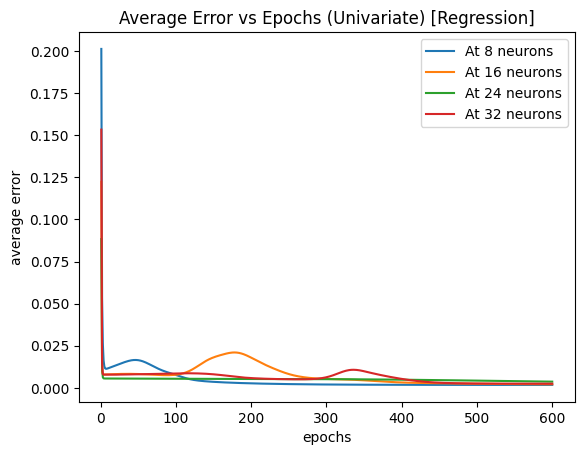

In [104]:
# Average error vs epochs

best_rmse_key = 0 
x_axis = np.arange(1, len(uni_average_error_dict[best_rmse_key]) + 1, 1)
colors = list(mcolors.TABLEAU_COLORS.values())

for i in range(len(single_layer_neurons) - 1): 
    plt.plot(x_axis, uni_average_error_dict[i], colors[i], label="At {} neurons".format(single_layer_neurons[i]))

plt.xlabel('epochs')
plt.ylabel('average error')
plt.title('Average Error vs Epochs (Univariate) [Regression]')
plt.legend()
plt.savefig("average_error_vs_epochs_multiple_archs_univariate_regression.png")
plt.show()

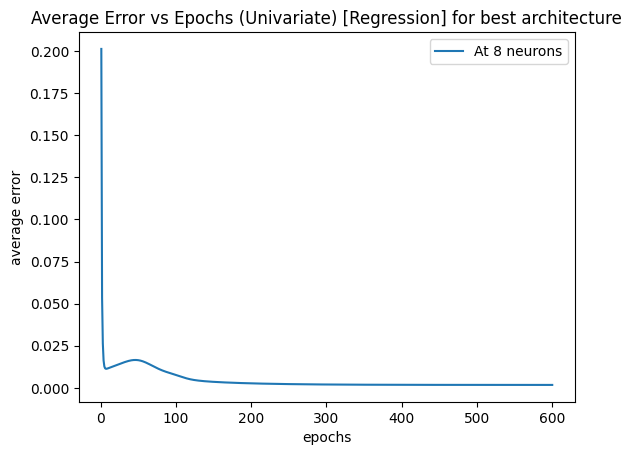

In [105]:
# Average error vs epoch (best arch)
best_rmse_key = 0 
x_axis = np.arange(1, len(uni_average_error_dict[best_rmse_key]) + 1, 1)
colors = list(mcolors.TABLEAU_COLORS.values())

i = 0
plt.plot(x_axis, uni_average_error_dict[i], colors[i], label="At {} neurons".format(single_layer_neurons[i]))

plt.xlabel('epochs')
plt.ylabel('average error')
plt.title('Average Error vs Epochs (Univariate) [Regression] for best architecture')
plt.legend()
plt.savefig("average_error_vs_epochs_best_univariate_regression.png")
plt.show()

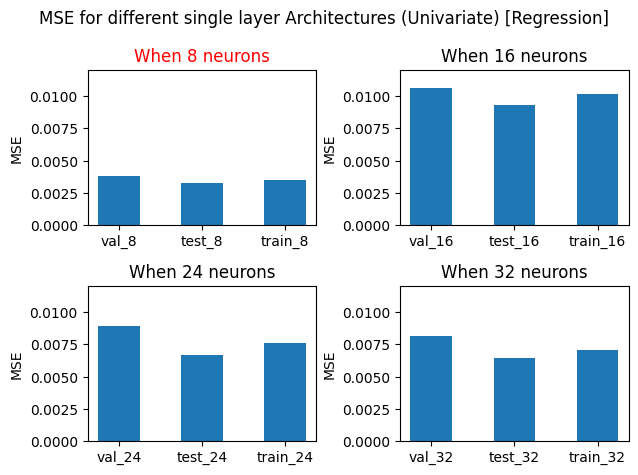

In [212]:
# MSE on train, test , val with different model complexities
# [8, 16, 24, 32]
mse_values = list(uni_mse_dict.values())
mse_labels = list(uni_mse_dict.keys())

n8 = mse_values[0:3]
n8_labels = ['val_8', 'test_8', 'train_8']
 
n16 = mse_values[3:6]
n16_labels = ['val_16', 'test_16', 'train_16']

n24 = mse_values[6:9]
n24_labels = ['val_24', 'test_24', 'train_24']

n32 = mse_values[9:12]
n32_labels = ['val_32', 'test_32', 'train_32']
 
# r1 = np.arange(3)
width1 = 0.5
 
# Create the first subplot
plt.subplot(2, 2, 1)
plt.bar(n8_labels, n8, width=width1)
plt.ylim(0, 0.012)
plt.title("When 8 neurons", color = 'r')
plt.ylabel('MSE')
plt.tight_layout()
 
plt.subplot(2, 2, 2)
plt.bar(n16_labels, n16, width=width1)
plt.title("When 16 neurons")
plt.ylabel('MSE')
plt.tight_layout()


plt.ylim(0, 0.012)
plt.subplot(2,2,3)
plt.bar(n24_labels, n24, width=width1)
plt.ylim(0, 0.012)
plt.title("When 24 neurons")
plt.ylabel('MSE')
plt.tight_layout()


plt.subplot(2,2,4)
plt.bar(n32_labels, n32, width=width1)
plt.ylim(0, 0.012)
plt.title("When 32 neurons")
plt.ylabel('MSE')
plt.tight_layout()

plt.suptitle('MSE for different single layer Architectures (Univariate) [Regression]')
plt.tight_layout()
plt.savefig("mse_uni_all_archs.png")
plt.show()

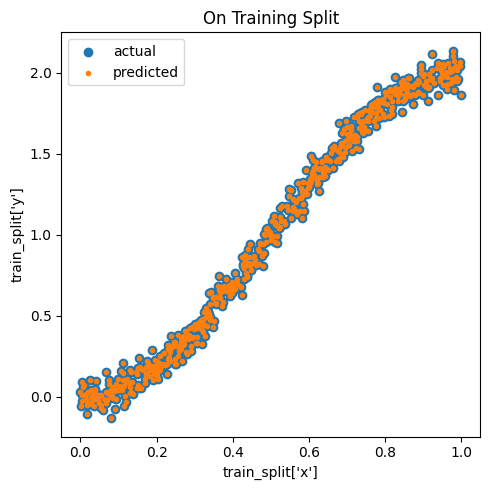

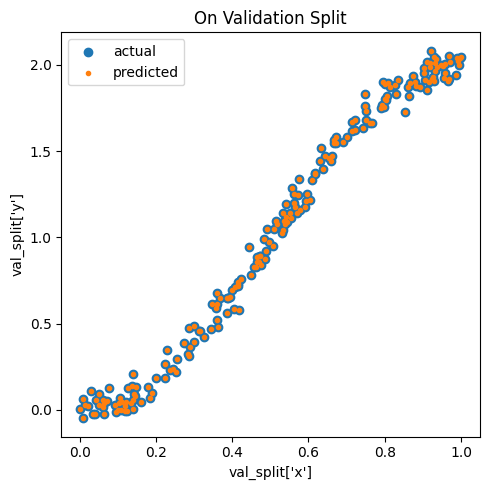

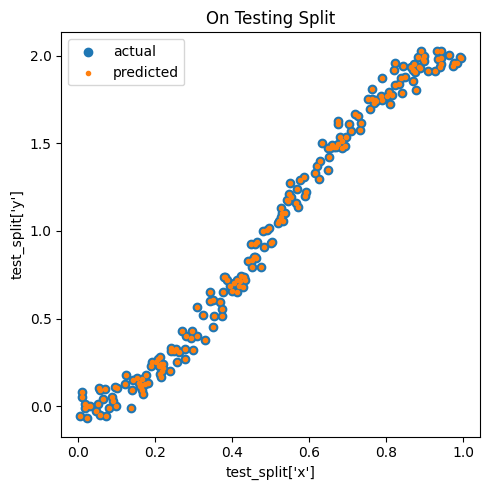

In [278]:
# model output and target output for training data, validation data and test data
# uni_validation_rmse, uni_average_error_dict, uni_best_arch_weights, uni_best_arch_rmse, uni_y_true, uni_y_pred, uni_mse_dict
model = FCNN()
btrain_y_true, btrain_y_pred, btrain_rmse = model.test_regressor(univariate_train_df, weights_dict=uni_best_arch_weights)
btest_y_true, btest_y_pred, btest_rmse = model.test_regressor(univariate_test_df, weights_dict=uni_best_arch_weights)
bval_y_true, bval_y_pred, bval_rmse = model.test_regressor(univariate_val_df, weights_dict=uni_best_arch_weights)

colors = list(mcolors.TABLEAU_COLORS.values())

plt.subplots(1,1, figsize = (5,5))
plt.scatter(univariate_train_df['x'], univariate_train_df['y'], color = colors[0], label="actual", marker='o')
plt.scatter(univariate_train_df['x'], btrain_y_true, color = colors[1], label="predicted", marker='.')
plt.title("On Training Split")
plt.ylabel("train_split['y']")
plt.xlabel("train_split['x']")
plt.legend()
plt.tight_layout()
plt.savefig("uni_model_output_vs_training_output_train.png")


# plt.subplot(3,3, 2, autoscale_on  = True)
plt.subplots(1,1, figsize = (5,5))
plt.scatter(univariate_val_df['x'], univariate_val_df['y'], color = colors[0], label="actual", marker='o')
plt.scatter(univariate_val_df['x'], bval_y_true, color = colors[1], label="predicted", marker='.')
plt.title("On Validation Split")
plt.ylabel("val_split['y']")
plt.xlabel("val_split['x']")
plt.legend()
plt.tight_layout()
plt.savefig("uni_model_output_vs_training_output_val.png")

# plt.subplot(3,3, 3, autoscale_on  = True)
plt.subplots(1,1, figsize = (5,5))
plt.scatter(univariate_test_df['x'], univariate_test_df['y'], color = colors[0], label="actual", marker='o')
plt.scatter(univariate_test_df['x'], btest_y_true, color = colors[1], label="predicted", marker='.')
plt.title("On Testing Split")
plt.ylabel("test_split['y']")
plt.xlabel("test_split['x']")
plt.legend()
plt.tight_layout()
plt.savefig("uni_model_output_vs_training_output_test.png")

plt.show()


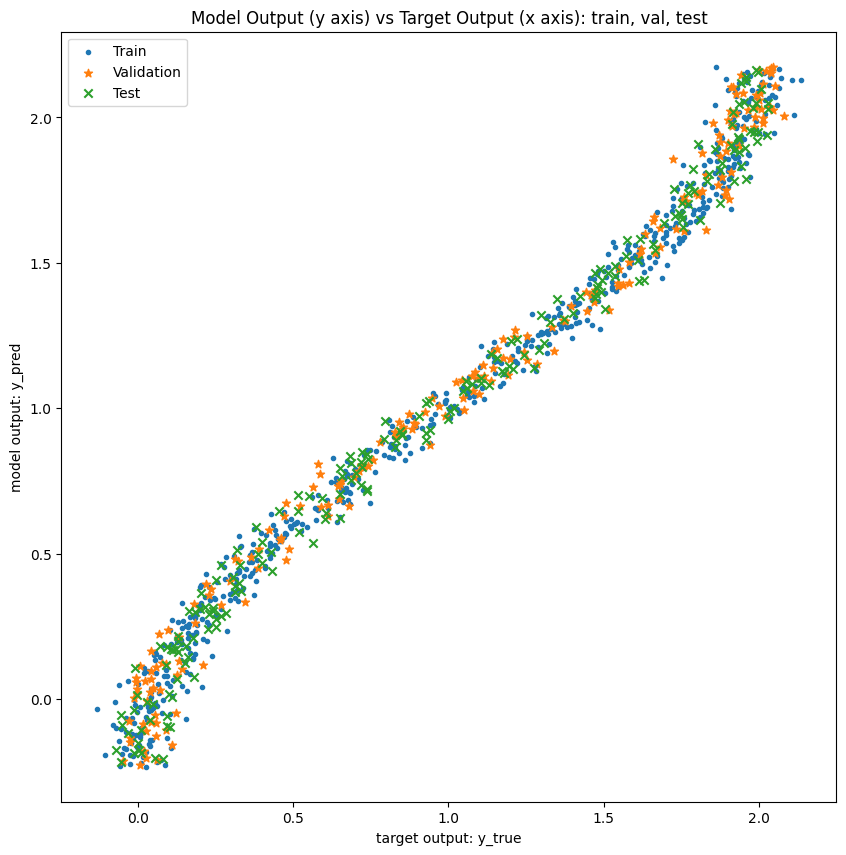

In [281]:
# model output(y axis) and target output (x axis)
plt.figure(figsize=(10, 10))
plt.scatter(btrain_y_true, btrain_y_pred, color = colors[0], label="Train", marker = '.')
plt.scatter(bval_y_true, bval_y_pred, color =colors[1], label="Validation", marker = '*')
plt.scatter(btest_y_true, btest_y_pred, color =colors[2], label="Test", marker = 'x')

plt.xlabel('target output: y_true')
plt.ylabel('model output: y_pred')
plt.title('Model Output (y axis) vs Target Output (x axis): train, val, test')
plt.legend()
plt.savefig("uni_model_output_vs_target_output_axes.png")
plt.show()

#### Neuronal Plots (Univariate)

In [ ]:
def get_df_for_nth_neuron(a_df, n=4, num_neurons=128):
  """
  a_df: class_wise df of [x1,x2,act]
  """
  df = a_df.iloc[n-1::num_neurons, :]
  return df

In [ ]:
n1df = get_df_for_nth_neuron(a_df, n=4, num_neurons=128)
n1dfc2 = get_df_for_nth_neuron(a_df_2, n=4, num_neurons=128)
n1dfc3 = get_df_for_nth_neuron(a_df_3, n=4, num_neurons=128)

In [292]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(n1df['x1'], n1df['x2'], n1df['act'], c='r', marker='o')
ax.scatter(n1dfc2['x1'], n1dfc2['x2'], n1dfc2['act'], c='g', marker='o')
ax.scatter(n1dfc3['x1'], n1dfc3['x2'], n1dfc3['act'], c='b', marker='o')
# plt.legend(['Class 1','Class 2','Class 3'])
plt.title("Neuron 1 activations")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.zlabel("Neuron Activation")
ax.set_xlabel("x1")

ax.set_ylabel("x2")

ax.set_zlabel("Neuron Activation")
plt.savefig("/content/neuron1.jpg")

plt.show

1

In [300]:

# uni_validation_rmse, uni_average_error_dict, uni_best_arch_weights, uni_best_arch_rmse, uni_y_true, uni_y_pred, uni_mse_dict
model = FCNN()

uni_y_true, uni_y_pred, rmse = model.get_neuronal_plots(test_data=univariate_test_df,\
                                                         weights_dict = uni_best_arch_weights)



dict_keys([0, 1, 2]) 17 {0: array([1.   , 0.281]), 1: array([1.        , 0.41426202, 0.50748313, 0.59414025, 0.25027304,
       0.54763675, 0.12897057, 0.163307  , 0.26963909, 0.49787698,
       0.88524356, 0.85290414, 0.9103719 , 0.90103795, 0.63846837,
       0.91691152, 0.64916614]), 2: array([0.46767696])}


### Bivariate Data

In [117]:
from sklearn.model_selection import train_test_split
# loading and splitting the data (train,val, test): (60, 20, 20)

bdf = pd.read_csv("Group07/Regression/BivariateData/7.csv", header= None, names=['x1','x2', 'y'])
bivariate_train_df = pd.DataFrame()
bivariate_test_df = pd.DataFrame()
bivariate_val_df = pd.DataFrame()
bivariate_train_df[['x1', 'x2']], xx, bivariate_train_df['y'], yy = train_test_split(bdf[['x1', 'x2']], bdf['y'], test_size=0.40, random_state=42)
bivariate_val_df[['x1', 'x2']], bivariate_test_df[['x1', 'x2']], bivariate_val_df['y'], bivariate_test_df['y'] = train_test_split(xx, yy, test_size=0.50, random_state=42)


1. Data Visualization for Bivariate Data

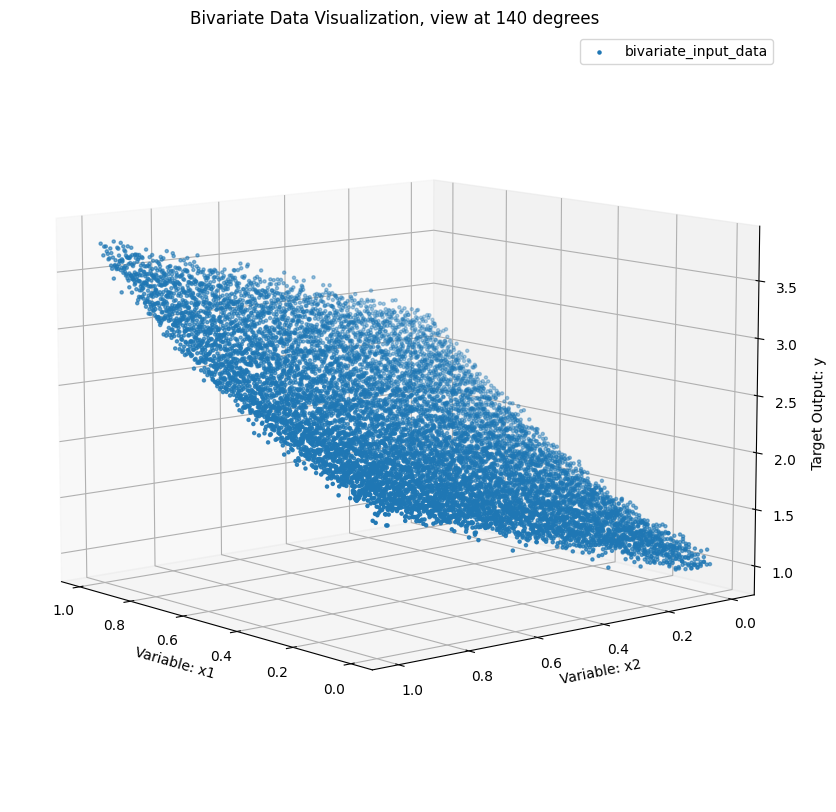

In [282]:
# 3D plotting for Bivariate Data Visualization

fig = plt.figure(figsize=(10,10))
plt.title
ax = fig.add_subplot(projection='3d')
ax.scatter(bdf['x1'], bdf['x2'], bdf['y'], marker='.', label = "bivariate_input_data")

ax.set_xlabel('Variable: x1')
ax.set_ylabel('Variable: x2')
ax.set_zlabel('Target Output: y')

for ii in range(0,210,70):
    ax.view_init(elev=10., azim=ii)
    plt.legend()
    plt.title("Bivariate Data Visualization, view at {} degrees".format(ii))
    # plt.savefig("bivariate%d.png" % ii)
plt.show()

In [168]:
# bi_validation_rmse, bi_average_error_dict, bi_best_arch_weights, \
#     bi_best_arch_rmse, bi_y_true, bi_y_pred, bi_mse_dict = \
#     get_final_val_metrics_reg(bivariate_train_df,\
#          bivariate_val_df, bivariate_test_df, lst= [4, 8, 16, 32], max_epochs= 100)

0
RMSE at 0.20677134950394663 architecture with ({1: 4, 2: 4}, {1: 4, 2: 4}) layer and Mean Average Error at 0.02730180669800375
1
RMSE at 0.2067235539414459 architecture with ({1: 8, 2: 8}, {1: 8, 2: 8}) layer and Mean Average Error at 0.01191976915204918
2
RMSE at 0.10631095394089463 architecture with ({1: 16, 2: 16}, {1: 16, 2: 16}) layer and Mean Average Error at 0.007138850382194077


In [169]:
bi_validation_rmse, bi_average_error_dict, bi_best_arch_weights, \
    bi_best_arch_rmse, bi_y_true, bi_y_pred, bi_mse_dict = \
    get_final_val_metrics_reg(bivariate_train_df,\
         bivariate_val_df, bivariate_test_df, lst= [4, 8, 16, 32, 64, 128], max_epochs= 100)

0
RMSE at 0.31546572596625483 architecture with ({1: 4, 2: 4}, {1: 4, 2: 4}) layer and Mean Average Error at 0.08473413463501815
1
RMSE at 0.12798166190767402 architecture with ({1: 8, 2: 8}, {1: 8, 2: 8}) layer and Mean Average Error at 0.01282327208584132
2
RMSE at 0.06467949568907988 architecture with ({1: 16, 2: 16}, {1: 16, 2: 16}) layer and Mean Average Error at 0.0023897223981760086
3
RMSE at 0.06425389965781225 architecture with ({1: 32, 2: 32}, {1: 32, 2: 32}) layer and Mean Average Error at 0.0021764255494077815
4
RMSE at 0.06713153776459178 architecture with ({1: 64, 2: 64}, {1: 64, 2: 64}) layer and Mean Average Error at 0.0023531502946913495
5
RMSE at 0.07378227456524607 architecture with ({1: 128, 2: 128}, {1: 128, 2: 128}) layer and Mean Average Error at 0.002842848249817465


In [170]:
final_bi_archs = bi_validation_rmse, bi_average_error_dict, bi_best_arch_weights, bi_best_arch_rmse, bi_y_true, bi_y_pred, bi_mse_dict

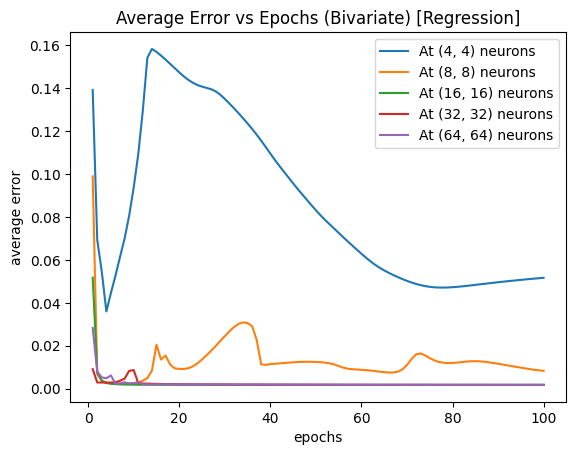

In [193]:
# Average error vs epochs (Bivariate)
two_hidden_layers = [4, 8, 16, 32, 64, 128]
# best performing at 3
x_axis = np.arange(1, len(bi_average_error_dict[3]) + 1, 1)
colors = list(mcolors.TABLEAU_COLORS.values())

for i in range(len(two_hidden_layers) - 1): 
    plt.plot(x_axis, bi_average_error_dict[i], colors[i], label="At ({0}, {1}) neurons".format(two_hidden_layers[i], two_hidden_layers[i]))

plt.xlabel('epochs')
plt.ylabel('average error')
plt.title('Average Error vs Epochs (Bivariate) [Regression]')
plt.legend()
plt.savefig("average_error_vs_epochs_multiple_archs_bivariate_regression.png")
plt.show()

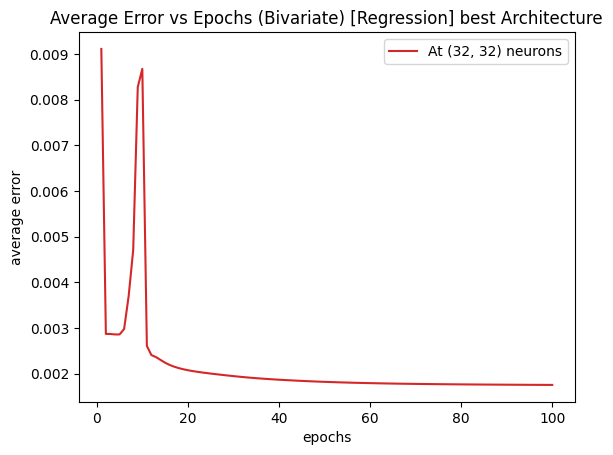

In [196]:
# Average error vs epochs (Bivariate)
two_hidden_layers = [4, 8, 16, 32, 64, 128]
# best performing at 3
x_axis = np.arange(1, len(bi_average_error_dict[3]) + 1, 1)
colors = list(mcolors.TABLEAU_COLORS.values())
i = 3
plt.plot(x_axis, bi_average_error_dict[i], colors[i], label="At ({0}, {1}) neurons".format(two_hidden_layers[i], two_hidden_layers[i]))

plt.xlabel('epochs')
plt.ylabel('average error')
plt.title('Average Error vs Epochs (Bivariate) [Regression] best Architecture')
plt.legend()
plt.savefig("average_error_vs_epochs_best_arch_bivariate_regression.png")
plt.show()

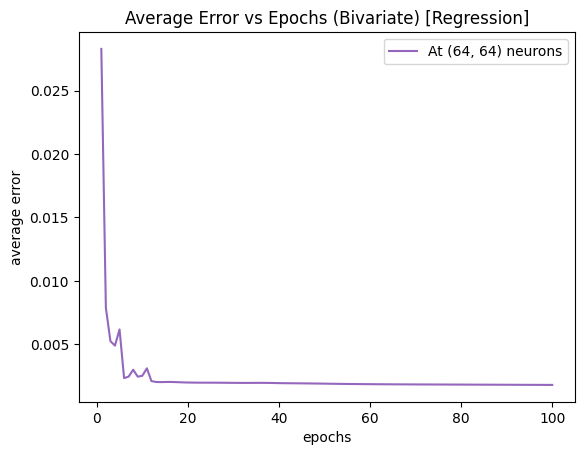

In [198]:
# Average error vs epochs (Bivariate)
two_hidden_layers = [4, 8, 16, 32, 64, 128]
# best performing at 3
x_axis = np.arange(1, len(bi_average_error_dict[3]) + 1, 1)
colors = list(mcolors.TABLEAU_COLORS.values())
i = 4
plt.plot(x_axis, bi_average_error_dict[i], colors[i], label="At ({0}, {1}) neurons".format(two_hidden_layers[i], two_hidden_layers[i]))

plt.xlabel('epochs')
plt.ylabel('average error')
plt.title('Average Error vs Epochs (Bivariate) [Regression]')
plt.legend()
plt.savefig("average_error_vs_epochs_64_arch_bivariate_regression.png")
plt.show()

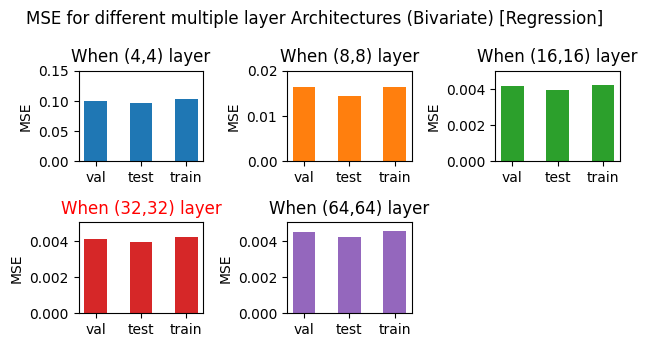

In [302]:
# MSE on train, test , val with different model complexities for bivariate
# [4, 8, 16, 32, 64]
mse_values = list(bi_mse_dict.values())
mse_labels = list(bi_mse_dict.keys())

n4 = mse_values[0:3]
n4_labels = ['val', 'test', 'train']
 
n8 = mse_values[3:6]
n8_labels = ['val', 'test', 'train']

n16 = mse_values[6:9]
n16_labels = ['val', 'test', 'train']

n32 = mse_values[9:12]
n32_labels = ['val', 'test', 'train']

n64 = mse_values[12:15]
n64_labels = ['val', 'test', 'train']
 
# r1 = np.arange(3)
width1 = 0.5
 
# Create the first subplot
plt.subplot(3,3, 1)
plt.bar(n4_labels, n4, width=width1, color = colors[0])
plt.ylim(0, 0.15)

plt.title("When (4,4) layer")
plt.ylabel('MSE')
plt.tight_layout()
 
plt.subplot(3, 3, 2)
plt.bar(n8_labels, n8, width=width1, color = colors[1])
plt.title("When (8,8) layer")
plt.ylabel('MSE')
plt.tight_layout()
plt.ylim(0, 0.02)

plt.subplot(3,3,3)
plt.bar(n16_labels, n16, width=width1, color = colors[2])
plt.ylim(0, max(n64)*1.1)


plt.title("When (16,16) layer")
plt.ylabel('MSE')
plt.tight_layout()


plt.subplot(3,3,4)
plt.bar(n32_labels, n32, width=width1, color = colors[3])
plt.ylim(0, max(n64)*1.1)

plt.title("When (32,32) layer", color = 'r')
plt.ylabel('MSE')
plt.tight_layout()

plt.subplot(3,3,5)
plt.bar(n64_labels, n64, width=width1, color = colors[4])
plt.ylim(0, max(n64)*1.1)
plt.title("When (64,64) layer")
plt.ylabel('MSE')
plt.tight_layout()

plt.suptitle('MSE for different multiple layer Architectures (Bivariate) [Regression]')
plt.tight_layout()
plt.savefig("mse_bivariate_all_archs.png")
plt.show()

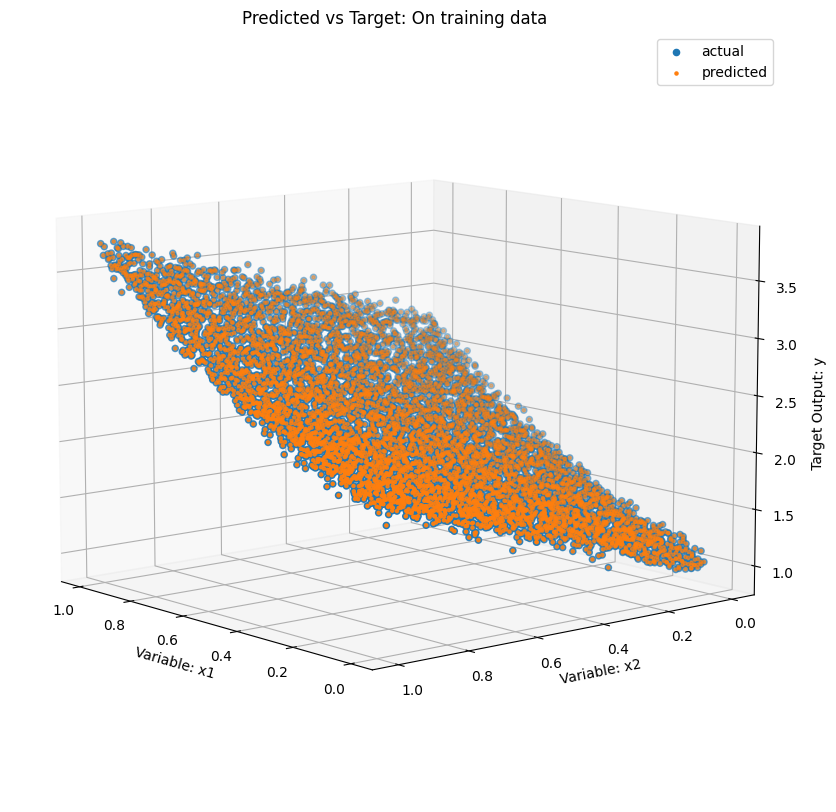

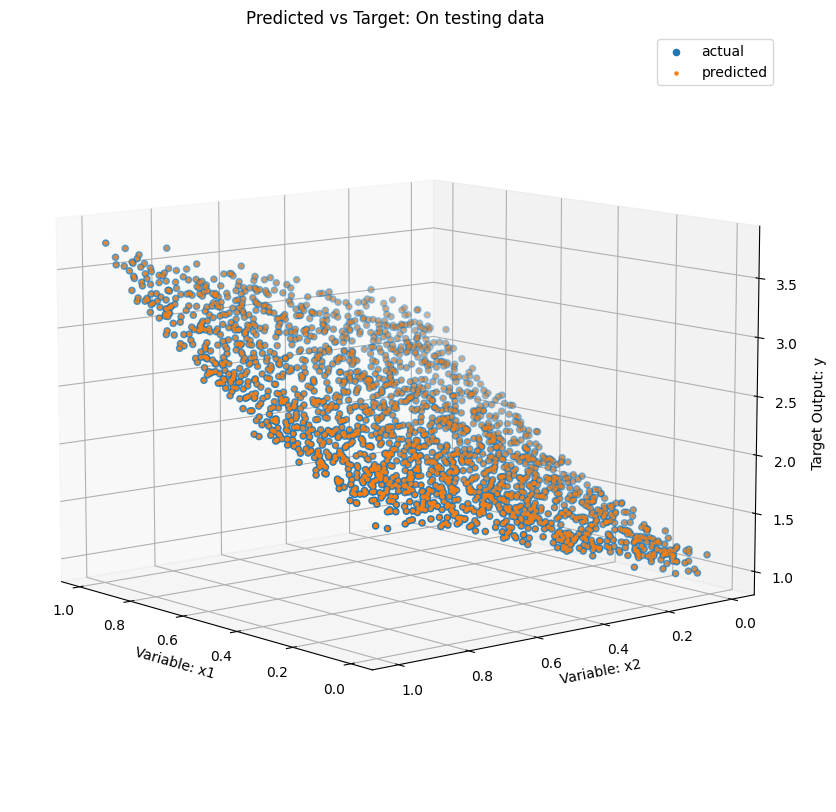

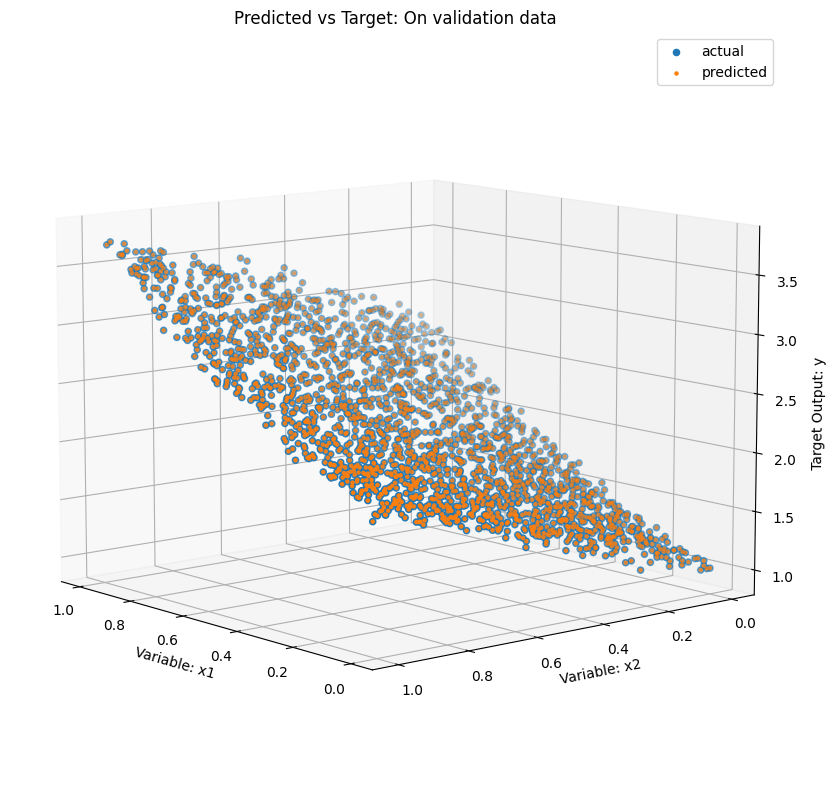

In [268]:
# model output and target output for training data, validation data and test data
# bi_validation_rmse, bi_average_error_dict, bi_best_arch_weights, bi_best_arch_rmse, bi_y_true, bi_y_pred, bi_mse_dict


model = FCNN()
btrain_y_true, btrain_y_pred, btrain_rmse = model.test_regressor(bivariate_train_df, weights_dict=bi_best_arch_weights)
btest_y_true, btest_y_pred, btest_rmse = model.test_regressor(bivariate_test_df, weights_dict=bi_best_arch_weights)
bval_y_true, bval_y_pred, bval_rmse = model.test_regressor(bivariate_val_df, weights_dict=bi_best_arch_weights)

colors = list(mcolors.TABLEAU_COLORS.values())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(bivariate_train_df['x1'], bivariate_train_df['x2'], bivariate_train_df['y'], color = colors[0], label="actual", marker='o')
ax.scatter(bivariate_train_df['x1'], bivariate_train_df['x2'], btrain_y_true, color = colors[1], label="predicted", marker='.')
ax.view_init(elev=10., azim=140)
ax.set_title("Predicted vs Target: On training data")
ax.set_xlabel('Variable: x1')
ax.set_ylabel('Variable: x2')
ax.set_zlabel('Target Output: y')
plt.legend()
plt.savefig("bi_target_vs_predicted_on_train.png")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(bivariate_test_df['x1'], bivariate_test_df['x2'], bivariate_test_df['y'], color = colors[0], label="actual", marker='o')
ax.scatter(bivariate_test_df['x1'], bivariate_test_df['x2'], btest_y_true, color = colors[1], label="predicted", marker='.')
ax.view_init(elev=10., azim=140)
ax.set_title("Predicted vs Target: On testing data")
ax.set_xlabel('Variable: x1')
ax.set_ylabel('Variable: x2')
ax.set_zlabel('Target Output: y')
plt.legend()

plt.savefig("bi_target_vs_predicted_on_test.png")



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(bivariate_val_df['x1'], bivariate_val_df['x2'], bivariate_val_df['y'], color = colors[0], label="actual", marker='o')
ax.scatter(bivariate_val_df['x1'], bivariate_val_df['x2'], bval_y_true, color = colors[1], label="predicted", marker='.')
ax.view_init(elev=10., azim=140)
ax.set_title("Predicted vs Target: On validation data")
ax.set_xlabel('Variable: x1')
ax.set_ylabel('Variable: x2')
ax.set_zlabel('Target Output: y')
plt.legend()

plt.savefig("bi_target_vs_predicted_on_val.png")


plt.show()

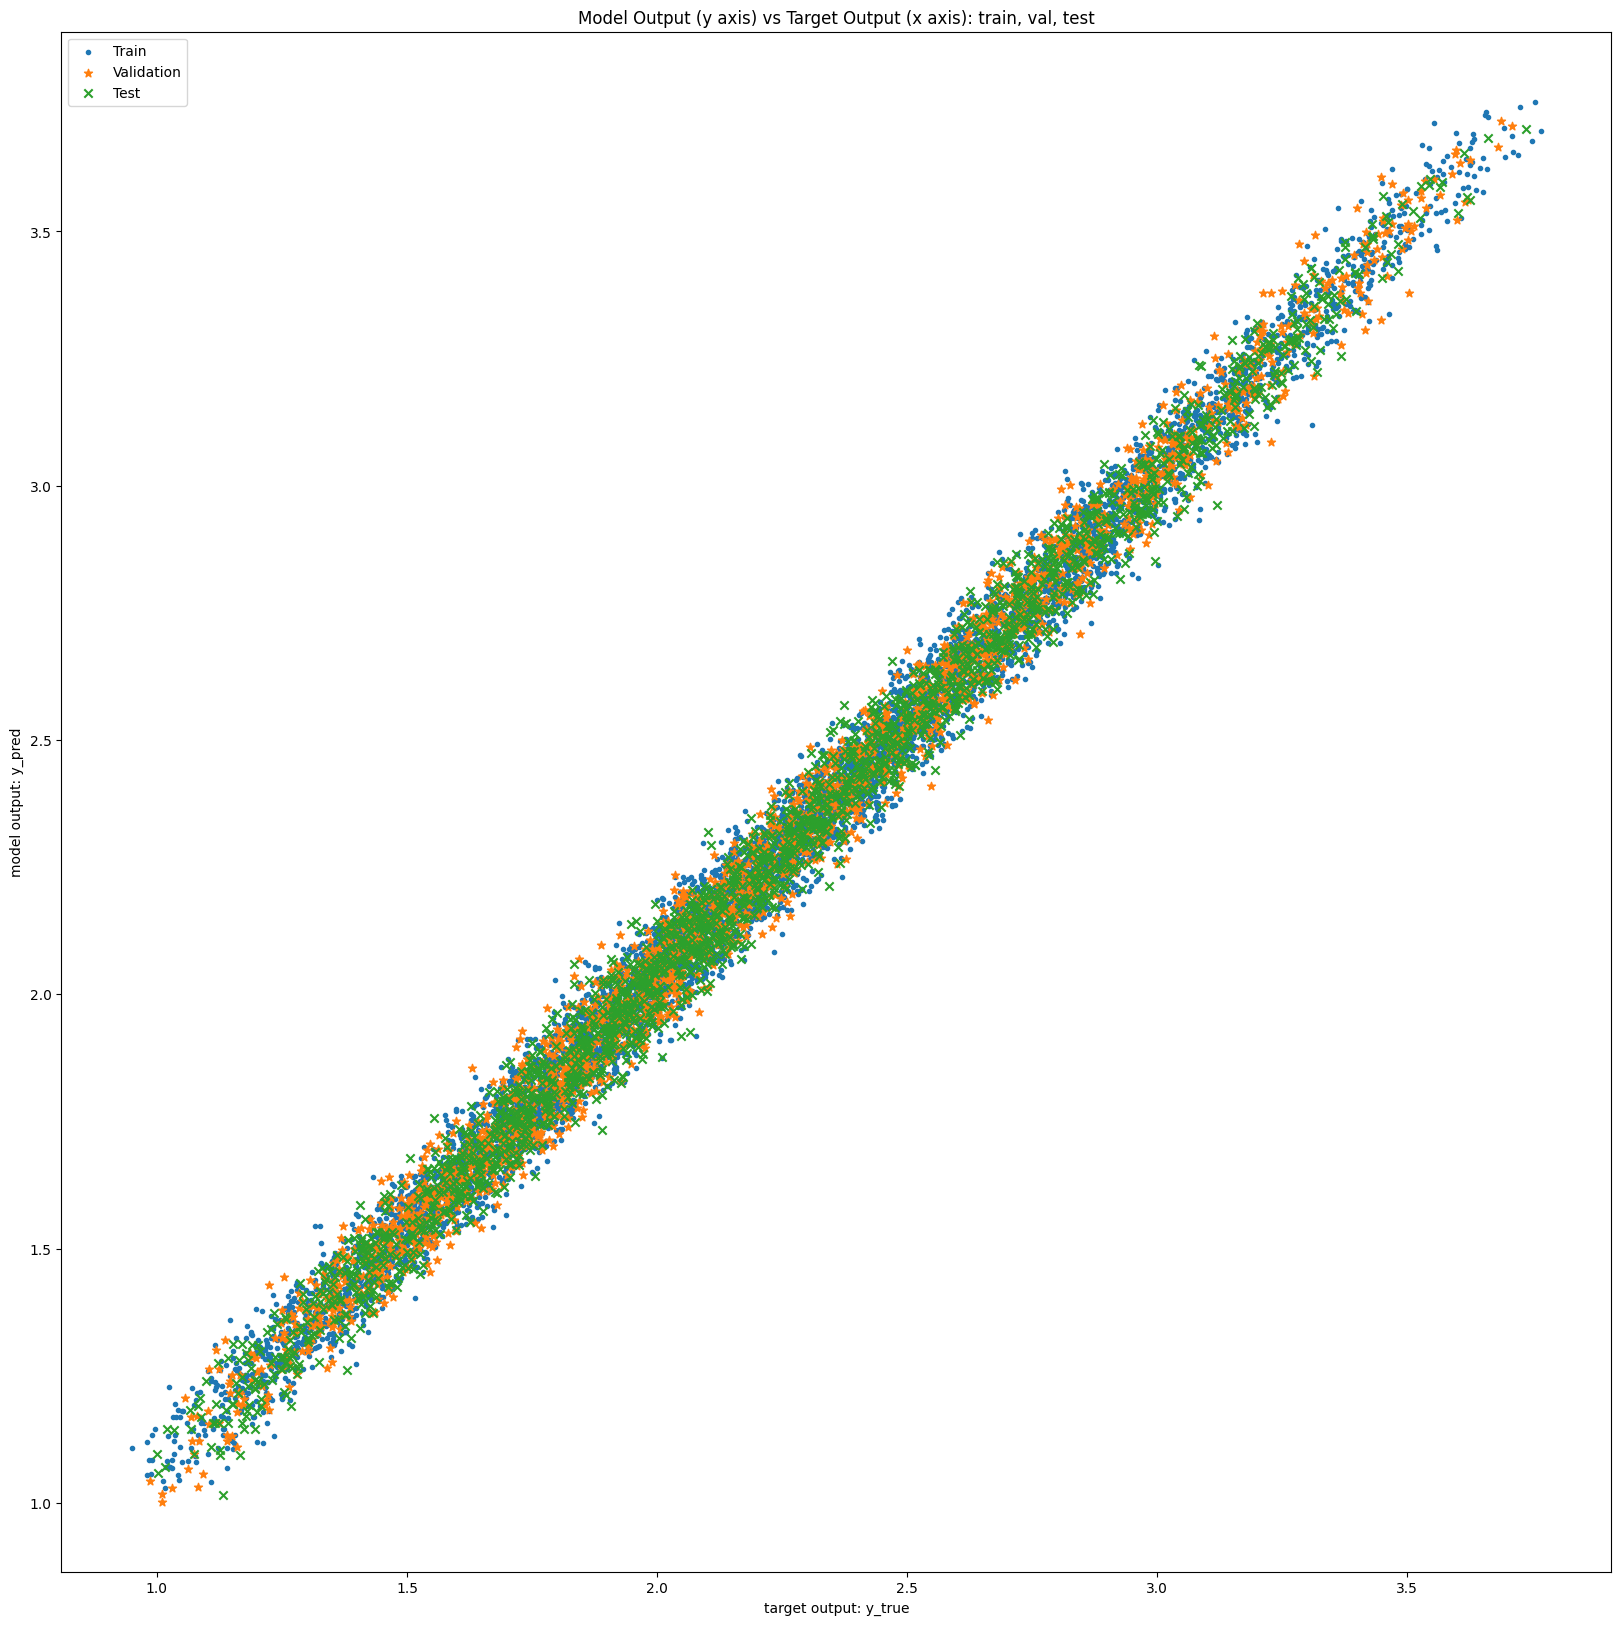

In [277]:
# model output(y axis) and target output (x axis)
plt.figure(figsize=(20,20))
plt.scatter(btrain_y_true, btrain_y_pred, color = colors[0], label="Train", marker = '.')
plt.scatter(bval_y_true, bval_y_pred, color =colors[1], label="Validation", marker = '*')
plt.scatter(btest_y_true, btest_y_pred, color =colors[2], label="Test", marker = 'x')

plt.xlabel('target output: y_true')
plt.ylabel('model output: y_pred')
plt.title('Model Output (y axis) vs Target Output (x axis): train, val, test')
plt.legend()
plt.savefig("bi_model_output_vs_target_output_axes.png")
plt.show()

In [ ]:
bi_validation_rmse, bi_average_error_dict, bi_best_arch_weights, \
    bi_best_arch_rmse, bi_y_true, bi_y_pred, bi_mse_dict

## Classification
### Linearly Separable Data

In [5]:
def classwise_data(class1_data, class2_data, class3_data):
    
    class1 = pd.read_csv(class1_data,  ' ', header = None, names=['c1', 'c2'])
    class1['class'] = 1
    class2 = pd.read_csv(class2_data,  ' ', header = None, names=['c1', 'c2'])
    class2['class'] = 2
    class3 = pd.read_csv(class3_data,  ' ', header = None, names=['c1', 'c2'])
    class3['class'] = 3
    
    return class1, class2, class3

In [6]:
def split_data(combined_df):
  replace = False#True  # with replacement
  fn = lambda obj: obj.loc[np.random.choice(obj.index, int(0.6*len(obj.index)), replace),:]
  train_data = combined_df.groupby('class', as_index=False, sort = False).apply(fn)
  train_data.index = train_data.index.droplevel()
  train_data = train_data.sample(frac = 1)
  test_val_data = combined_df.drop(train_data.index).sample(frac = 1)
  fn2 = lambda obj: obj.loc[np.random.choice(obj.index, int(0.5*len(obj.index)), replace),:]
  val_data = test_val_data.groupby('class', as_index=False, sort = False).apply(fn2)
  val_data.index = val_data.index.droplevel()
  val_data = val_data.sample(frac = 1)
  test_data = test_val_data.drop(val_data.index).sample(frac = 1)
  return train_data, val_data, test_data

In [304]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
mod_ = FCNN()
a_df = pd.DataFrame(columns =['x1','x2', 'act'])
# for i in range(5):
for i in range(nls_class1.shape[0]):
  df_ = nls_class1.iloc[i, :-1]
  # print(df_)
  x_n= np.hstack([np.ones((1)), df_])
  # 
  weighted_inps, layer_ops = mod_.fcnn_forward(x_n, nls_weights_dict)
  z = layer_ops[1][1:].reshape(-1,1)
  # print(z)
  # 
  df_ = df_.to_numpy().reshape(1,-1)
  # print(x_n.shape)
  r_a = np.repeat(df_, repeats=128, axis=0)
  r_a = np.hstack((r_a, z))
  tmp_df = pd.DataFrame(r_a,columns=['x1', 'x2', 'act'])
  # a_df
  a_df = pd.concat([a_df,tmp_df])

a_df

In [ ]:
def get_plot_df(class_dataframe, weights_dict):
  # for i in range(nls_class1.shape[0]):
  mod_ = FCNN()
  a_df = pd.DataFrame(columns =['x1','x2', 'act'])
  # for i in range(5):
  for i in range(class_dataframe.shape[0]):
    df_ = class_dataframe.iloc[i, :-1]
    # print(df_)
    x_n= np.hstack([np.ones((1)), df_])
    # 
    weighted_inps, layer_ops = mod_.fcnn_forward(x_n, weights_dict)
    z = layer_ops[1][1:].reshape(-1,1)
    # print(z)
    # 
    df_ = df_.to_numpy().reshape(1,-1)
    # print(x_n.shape)
    r_a = np.repeat(df_, repeats=128, axis=0)
    r_a = np.hstack((r_a, z))
    tmp_df = pd.DataFrame(r_a,columns=['x1', 'x2', 'act'])
    # a_df
    a_df = pd.concat([a_df,tmp_df])
  return a_df

In [ ]:
a_df_2 = get_plot_df(nls_class2, nls_weights_dict)
a_df_3 = get_plot_df(nls_class3, nls_weights_dict)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(a_df['x1'], a_df['x2'], a_df['act'], c='r', marker='o')
ax.scatter(a_df_2['x1'], a_df_2['x2'], a_df_2['act'], c='g', marker='o')
ax.scatter(a_df_3['x1'], a_df_3['x2'], a_df_3['act'], c='b', marker='o')
plt.legend(['Class 1','Class 2','Class 3'])
plt.title("Neuron 1 activations")


plt.show

In [7]:
# Loading and training model for Linearly Separable Data
class1_data = 'Group07/Classification/LS_Group07/Class1.txt'
class2_data = 'Group07/Classification/LS_Group07/Class2.txt'
class3_data = 'Group07/Classification/LS_Group07/Class3.txt'


class1, class2, class3 = classwise_data(class1_data, class2_data, class3_data)
ls_df = pd.concat([class1, class2, class3]).reset_index(drop=True)
# train, test, and validate datasets
ls_train_data, ls_val_data, ls_test_data = split_data(ls_df)

ls_classification_model = FCNN()
layer_neurons_dict = {1: 128, 2:256}

ls_average_error, ls_weight_dict = ls_classification_model.train_fcnn_clf(ls_train_data, 0.01, 150, 3, layer_neurons_dict)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  import sys


In [13]:
model.test_clf(train_data, nls_weights_dict)

pandas.core.series.Series